# Agricultural Land Area (percentage of total land area)
In this notebook we will predict agricultural land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing agricultural data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging the forest area percentage variable  

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Mixed effect linear regression base line models
    - Fitting baseline model (mean model)
    - Fitting simple mixed effects model (time, population)
    
- Mixed effect linear regression theory driven models (social)
    - Social theory driven model 
    - Full social model 

- Mixed effect linear regression theory driven models (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model

Model comparison: 
- Compare model predictions 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Read file 
df = pd.read_excel('Data/agro_sqkm.xlsx')



Removing 0 count countries and non-ISO countries.

In [3]:
summary = df.describe()

# Get the row corresponding to the count statistic
count_row = summary.loc['count']

# Filter for columns where the count is 0.0
columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

#Removing zero count columns from data
df_full = df.drop(columns=columns_with_zero_count)

print(df_full)

                    Country Name Country Code              Indicator Name  \
0                          Aruba          ABW  Agricultural land (sq. km)   
1    Africa Eastern and Southern          AFE  Agricultural land (sq. km)   
2                    Afghanistan          AFG  Agricultural land (sq. km)   
3     Africa Western and Central          AFW  Agricultural land (sq. km)   
4                         Angola          AGO  Agricultural land (sq. km)   
..                           ...          ...                         ...   
261                       Kosovo          XKX  Agricultural land (sq. km)   
262                  Yemen, Rep.          YEM  Agricultural land (sq. km)   
263                 South Africa          ZAF  Agricultural land (sq. km)   
264                       Zambia          ZMB  Agricultural land (sq. km)   
265                     Zimbabwe          ZWE  Agricultural land (sq. km)   

     Indicator Code       1961       1962       1963       1964       1965 

In [4]:
#Removing non countries 

ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

df_iso = df_full[df_full['Country Code'].isin(ISO_list)]


In [5]:
#Making df long
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='agricultural_land')

melted_df['Year'] = melted_df['Year'].astype(float)

print(melted_df)

      Country Code  Country Name              Indicator Name  Indicator Code  \
0              ABW         Aruba  Agricultural land (sq. km)  AG.LND.AGRI.K2   
1              AFG   Afghanistan  Agricultural land (sq. km)  AG.LND.AGRI.K2   
2              AGO        Angola  Agricultural land (sq. km)  AG.LND.AGRI.K2   
3              ALB       Albania  Agricultural land (sq. km)  AG.LND.AGRI.K2   
4              AND       Andorra  Agricultural land (sq. km)  AG.LND.AGRI.K2   
...            ...           ...                         ...             ...   
13110          WSM         Samoa  Agricultural land (sq. km)  AG.LND.AGRI.K2   
13111          YEM   Yemen, Rep.  Agricultural land (sq. km)  AG.LND.AGRI.K2   
13112          ZAF  South Africa  Agricultural land (sq. km)  AG.LND.AGRI.K2   
13113          ZMB        Zambia  Agricultural land (sq. km)  AG.LND.AGRI.K2   
13114          ZWE      Zimbabwe  Agricultural land (sq. km)  AG.LND.AGRI.K2   

         Year  agricultural_land  
0   

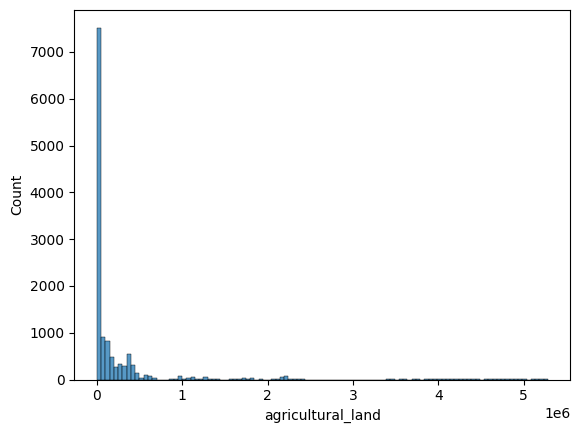

In [8]:
sns.histplot(data=melted_df, x='agricultural_land', binwidth=50000)
plt.show()

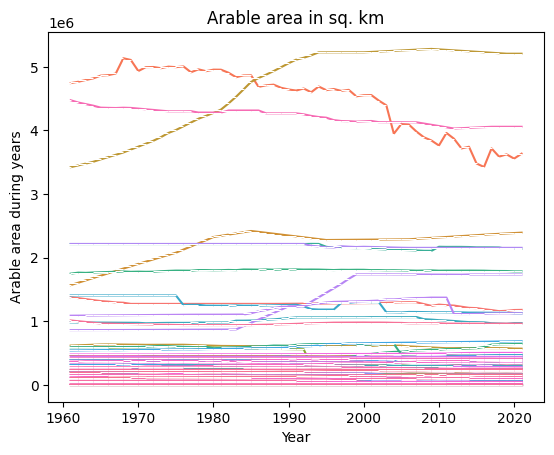

In [10]:
sns.lineplot(data=melted_df, x='Year', y='agricultural_land', hue='Country Name', marker=False, legend=False)

# Add title and labels
plt.title('Arable area in sq. km')
plt.xlabel('Year')
plt.ylabel('Arable area during years')


# Show the plot
plt.show()

### Combine with predictor data 

In [11]:
#Changing name 
agro = melted_df

In [12]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                           Country Name Country Code  Year  Population, total  \
0                                 Aruba          ABW  1960            54608.0   
1           Africa Eastern and Southern          AFE  1960        130692579.0   
2                           Afghanistan          AFG  1960          8622466.0   
3            Africa Western and Central          AFW  1960         97256290.0   
4                                Angola          AGO  1960          5357195.0   
...                                 ...          ...   ...                ...   
17769                         Swaziland          SWZ  2021                NaN   
17770      Tanzania, United Republic of          TZA  2021                NaN   
17771                            Turkey          TUR  2021                NaN   
17772  Venezuela, Bolivarian Republic o          VEN  2021                NaN   
17773                             Yemen          YEM  2021                NaN   

       Land area (sq. km)  

In [13]:
#Renaming so no double names
agro = agro.rename(columns={'Country Name':'Country'})

#combining forest and pred data
agro_full = pd.merge(agro, pred, on = ['Year', 'Country Code'], how = 'inner')

#removing excess country column
agro_full = agro_full.drop(columns=['Country'])

display(agro_full)

,Country Code,Indicator Name,Indicator Code,Year,agricultural_land,Country Name,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,ABW,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,20.0,Aruba,55811.0,180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,377500.0,Afghanistan,8790140.0,652230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AGO,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,451770.0,Angola,5441333.0,1246700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ALB,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,12320.0,Albania,1659800.0,27400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AND,Agricultural land (sq. km),AG.LND.AGRI.K2,1961.0,260.0,Andorra,10216.0,470.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,YEM,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,234520.0,"Yemen, Rep.",32981641.0,527970.0,-1.680930,-2.580310,-2.324521,-2.040683,-1.802895,-1.668239,NaN,20.0,NaN,16.988239,NaN
13928,YEM,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,234520.0,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.695925
13929,ZAF,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,963410.0,South Africa,59392255.0,1213090.0,0.770391,-0.750981,-0.071013,-0.090709,0.069080,-0.034114,25.23908,1804.0,NaN,58.085488,0.422920
13930,ZMB,Agricultural land (sq. km),AG.LND.AGRI.K2,2021.0,238390.0,Zambia,19473125.0,743390.0,-0.369448,0.052348,-0.841102,-0.570348,-0.607838,-0.759728,NaN,13.0,NaN,34.908994,0.762396


In [14]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
agro_full_filtered = agro_full[(agro_full['Year'] >= 1996) & (agro_full['Year'] <= 2020)]

#forest_full_filtered.info()

# Identify countries with NaN in forest_area (total of 8 countries)
countries_with_nan = agro_full_filtered[
    (agro_full_filtered['agricultural_land'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
agro_full_filtered = agro_full_filtered[~agro_full_filtered['Country Code'].isin(countries_with_nan)]

#Checkin how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))


207
215


In [15]:
# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'agricultural_land', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = agro_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
agro_full_filtered = agro_full_filtered[agro_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

#Checking how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))

195
215


In [16]:
# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = agro_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
agro_full_filtered = agro_full_filtered[~agro_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

#Checking how many countries were removed
print(len(agro_full_filtered['Country Code'].unique()))
print(len(agro_full['Country Code'].unique()))

Countries removed using country code: ['KNA', 'COG', 'CIV', 'VCT', 'YEM', 'VEN', 'BHS', 'FSM', 'LCA', 'ASM', 'PRK', 'CZE', 'LAO', 'VNM', 'STP', 'HKG', 'GMB', 'SWZ', 'CPV', 'LIE', 'IRN', 'KOR', 'BOL', 'PRI', 'ABW', 'MDA', 'GUM', 'GRL', 'KGZ', 'CYM', 'BMU', 'TZA', 'TUR', 'MKD', 'SVK', 'LBY', 'EGY', 'VIR']
157
215


In [17]:
print(agro_full_filtered.isna().sum())

Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
agricultural_land        0
Country Name             0
Population, total        0
Land area (sq. km)      15
WGI VA                   0
WGI PS                  34
WGI GE                  69
WGI RQ                  69
WGI RL                   1
WGI CC                  54
Education             1196
Innovation            1543
Social Inequality     2135
ICT                    797
Health                   0
dtype: int64


We end up with 157 countries and very few NaN in relevant columns.

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = agro_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'agricultural_land', 'Education', 'Innovation', 'Social Inequality'
]

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
agro_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(forest_full_imputed)


Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [19]:
print(agro_full_imputed.isna().sum())

Country Code             0
Country Name             0
Indicator Name           0
Indicator Code           0
Year                     0
agricultural_land        0
Education             1196
Innovation            1543
Social Inequality     2135
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64


In [20]:
agro_full_imputed = agro_full_imputed.drop(columns=['Indicator Name', 'Indicator Code', 'Education', 'Innovation', 'Social Inequality'])
agro_full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        3453 non-null   object 
 1   Country Name        3453 non-null   object 
 2   Year                3453 non-null   float64
 3   agricultural_land   3453 non-null   float64
 4   Population, total   3453 non-null   float64
 5   Land area (sq. km)  3453 non-null   float64
 6   WGI VA              3453 non-null   float64
 7   WGI PS              3453 non-null   float64
 8   WGI GE              3453 non-null   float64
 9   WGI RQ              3453 non-null   float64
 10  WGI RL              3453 non-null   float64
 11  WGI CC              3453 non-null   float64
 12  ICT                 3453 non-null   float64
 13  Health              3453 non-null   float64
dtypes: float64(12), object(2)
memory usage: 377.8+ KB


Delaying the forest area variable.

In [21]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
agro_full_imputed['lagged_agro'] = pd.NA

#Iterating over each row
for i in range(len(agro_full_imputed)):
    country = agro_full_imputed.loc[i, 'Country Code']
    year = agro_full_imputed.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = agro_full_imputed[(agro_full_imputed['Country Code'] == country) & (agro_full_imputed['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        agro_full_imputed.loc[i, 'lagged_agro'] = lagged_row['agricultural_land'].values[0]

#Display the new dataframe 
display(agro_full_imputed)

,Country Code,Country Name,Year,agricultural_land,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_agro
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,ZWE,Zimbabwe,2016.0,162000.0,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,162000.0
3449,ZWE,Zimbabwe,2017.0,162000.0,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3450,ZWE,Zimbabwe,2018.0,162000.0,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3451,ZWE,Zimbabwe,2019.0,162000.0,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [22]:
#Checking if the lagged is correct 
print(agro_full_imputed[(agro_full_imputed['Country Code'] == 'ZWE') & (agro_full_imputed['Year'] == 2000.0)]['agricultural_land'])

print(agro_full_imputed[(agro_full_imputed['Country Code'] == 'ZWE') & (agro_full_imputed['Year'] == 1996.0)]['lagged_agro'])

3433    150600.0
Name: agricultural_land, dtype: float64
3431    150600.0
Name: lagged_agro, dtype: object


In [23]:
agro_full_imputed['lagged_agro'] = pd.to_numeric(agro_full_imputed['lagged_agro'])
agro_full_imputed = agro_full_imputed.rename(columns={'Land area (sq. km)':'land_area'})
agro_full_imputed = agro_full_imputed.rename(columns={'Population, total':'population'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI VA':'WGI_va'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI GE':'WGI_ge'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI RL':'WGI_rl'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI RQ':'WGI_rq'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI PS':'WGI_ps'})
agro_full_imputed = agro_full_imputed.rename(columns={'WGI CC':'WGI_cc'})
agro_full_imputed =agro_full_imputed.dropna()

display(agro_full_imputed)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,ZWE,Zimbabwe,2012.0,162000.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,162000.0
3445,ZWE,Zimbabwe,2013.0,162000.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,162000.0
3446,ZWE,Zimbabwe,2014.0,162000.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,162000.0
3447,ZWE,Zimbabwe,2015.0,162000.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,162000.0


In [24]:
print(agro_full_imputed.isna().sum())
print(len(agro_full_imputed['Country Code'].unique()))

Country Code         0
Country Name         0
Year                 0
agricultural_land    0
population           0
land_area            0
WGI_va               0
WGI_ps               0
WGI_ge               0
WGI_rq               0
WGI_rl               0
WGI_cc               0
ICT                  0
Health               0
lagged_agro          0
dtype: int64
157


In [57]:
agro_full_imputed['log_lagged_agro'] = np.log(agro_full_imputed['lagged_agro'])

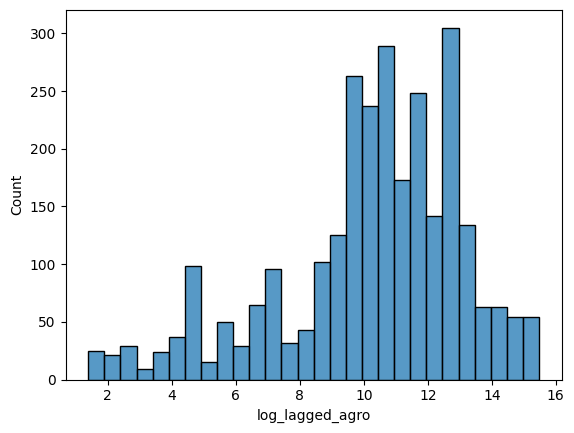

In [58]:
sns.histplot(data=agro_full_imputed, x='log_lagged_agro', binwidth=.5)
plt.show()

In [71]:
agro = agro_full_imputed

agro_size = agro[['Country Code', 'land_area', 'Year']]

agro_group = agro_size.groupby('Country Code')['land_area'].mean()


agro_size_mean = agro_group.reset_index(name='mean_land_area')
display(agro_size_mean)

#Sort forest by population in ascending order
agro_size_mean = agro_size_mean.sort_values(by='mean_land_area', ascending=True).reset_index(drop=True)

agro_size_mean['Size_rank'] = agro_size_mean.index + 1

display(agro_size_mean)

,Country Code,mean_land_area
0,AFG,652230.0
1,AGO,1246700.0
2,ALB,27400.0
3,ARE,71020.0
4,ARG,2736690.0
...,...,...
152,VUT,12190.0
153,WSM,2830.0
154,ZAF,1213090.0
155,ZMB,743390.0


,Country Code,mean_land_area,Size_rank
0,NRU,2.000000e+01,1
1,TUV,3.000000e+01,2
2,SMR,6.000000e+01,3
3,MHL,1.800000e+02,4
4,MDV,3.000000e+02,5
...,...,...,...
152,BRA,8.358140e+06,153
153,CAN,8.965590e+06,154
154,USA,9.154341e+06,155
155,CHN,9.388214e+06,156


In [73]:
#Merging the size rank into ghg again
agro = agro.merge(agro_size_mean[['Country Code', 'Size_rank']], on='Country Code')
display(agro)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro,z_lagged_agro,log_lagged_agro,Size_rank
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0,12.842491,12.842491,126
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0,12.842385,12.842385,126
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0,12.846030,12.846030,126
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0,12.845555,12.845555,126
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0,12.845661,12.845661,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,ZWE,Zimbabwe,2012.0,162000.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,162000.0,11.995352,11.995352,108
2821,ZWE,Zimbabwe,2013.0,162000.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,162000.0,11.995352,11.995352,108
2822,ZWE,Zimbabwe,2014.0,162000.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,162000.0,11.995352,11.995352,108
2823,ZWE,Zimbabwe,2015.0,162000.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,162000.0,11.995352,11.995352,108


### Save combined clean data 

In [74]:
agro.to_csv('git_data/agricultural-modelling.csv', index=False)

# Data exploration

In [75]:
#Load in cleaned data 
agro = pd.read_csv('git_data/agricultural-modelling.csv')

agro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2825 entries, 0 to 2824
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Code       2825 non-null   object 
 1   Country Name       2825 non-null   object 
 2   Year               2825 non-null   float64
 3   agricultural_land  2825 non-null   float64
 4   population         2825 non-null   float64
 5   land_area          2825 non-null   float64
 6   WGI_va             2825 non-null   float64
 7   WGI_ps             2825 non-null   float64
 8   WGI_ge             2825 non-null   float64
 9   WGI_rq             2825 non-null   float64
 10  WGI_rl             2825 non-null   float64
 11  WGI_cc             2825 non-null   float64
 12  ICT                2825 non-null   float64
 13  Health             2825 non-null   float64
 14  lagged_agro        2825 non-null   float64
 15  z_lagged_agro      2825 non-null   float64
 16  log_lagged_agro    2825 

In [76]:
display(agro)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro,z_lagged_agro,log_lagged_agro,Size_rank
0,AFG,Afghanistan,1996.0,377570.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,377940.0,12.842491,12.842491,126
1,AFG,Afghanistan,1998.0,378680.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,377900.0,12.842385,12.842385,126
2,AFG,Afghanistan,2000.0,377940.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,379280.0,12.846030,12.846030,126
3,AFG,Afghanistan,2002.0,377900.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,379100.0,12.845555,12.845555,126
4,AFG,Afghanistan,2003.0,378840.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,379140.0,12.845661,12.845661,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,ZWE,Zimbabwe,2012.0,162000.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,162000.0,11.995352,11.995352,108
2821,ZWE,Zimbabwe,2013.0,162000.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,162000.0,11.995352,11.995352,108
2822,ZWE,Zimbabwe,2014.0,162000.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,162000.0,11.995352,11.995352,108
2823,ZWE,Zimbabwe,2015.0,162000.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,162000.0,11.995352,11.995352,108


### Plotting and data exploration

Agro area per country over years.

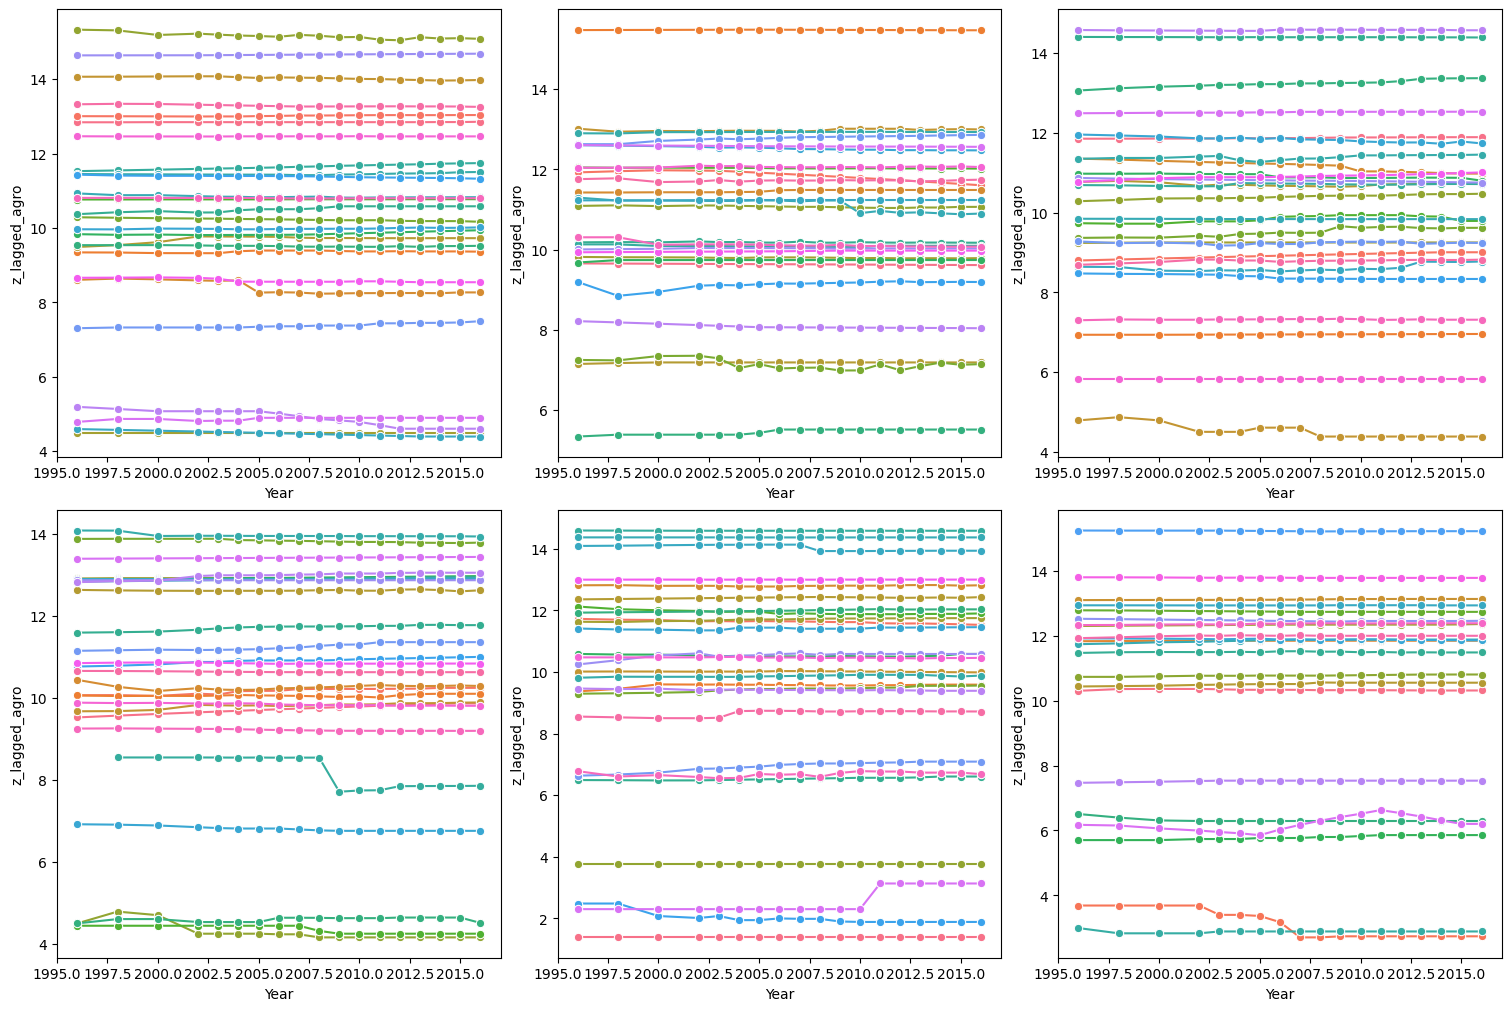

In [43]:
#Dividing by contries
countries = agro['Country Code'].unique()
countries_per_fig = 27
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = agro[agro['Country Code'].isin(group)]
    sns.lineplot(x='Year', y='z_lagged_agro', data= data, hue = 'Country Code', marker='o', legend=False, ax=ax)
    #ax.set_title(f'Boxplot of GHG values by Country - Group {i + 1}')
    #ax.set_xlabel('Country Code')
    #ax.set_ylabel('GHG Values')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

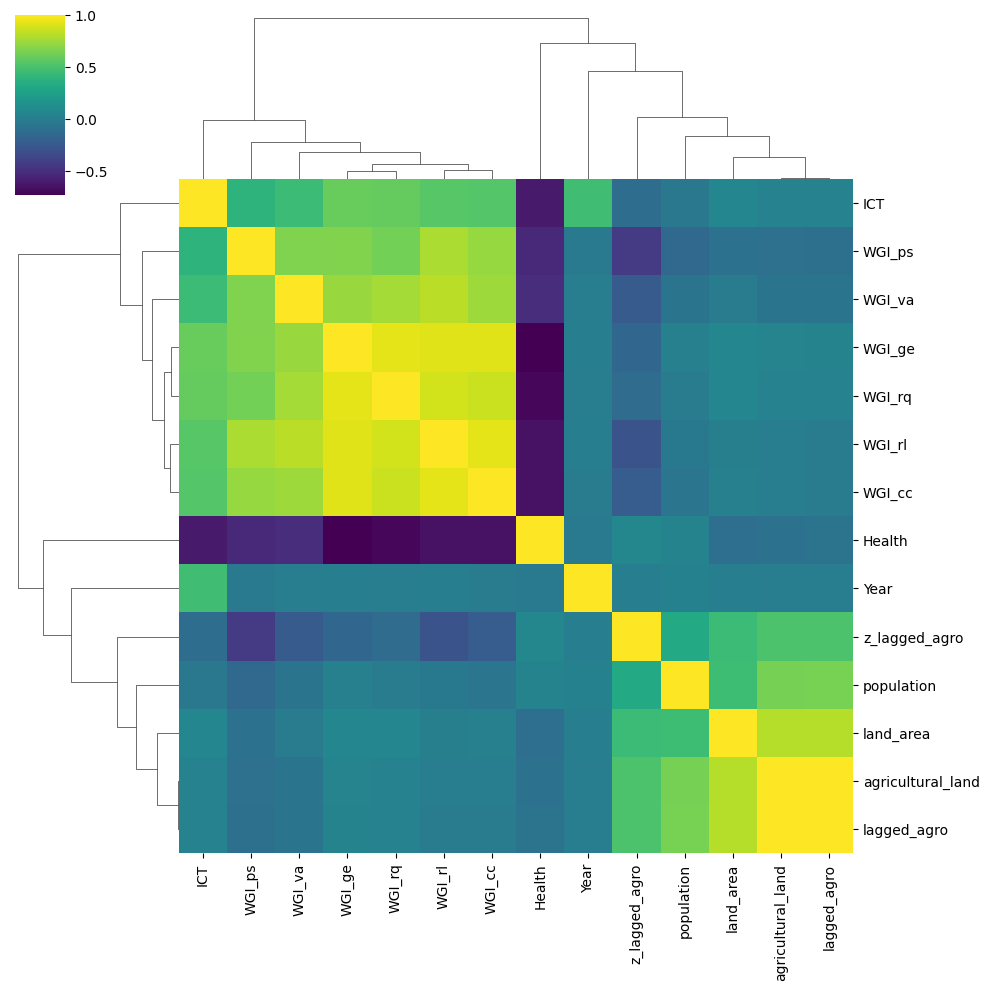

In [44]:
agro_num = agro[agro.select_dtypes(exclude=['object']).columns]

sns.clustermap(agro_num.corr(), cmap='viridis')
plt.show()

### Checking for/Reducing outliers 

In [45]:
agro = pd.read_csv('git_data/agricultural-modelling.csv')

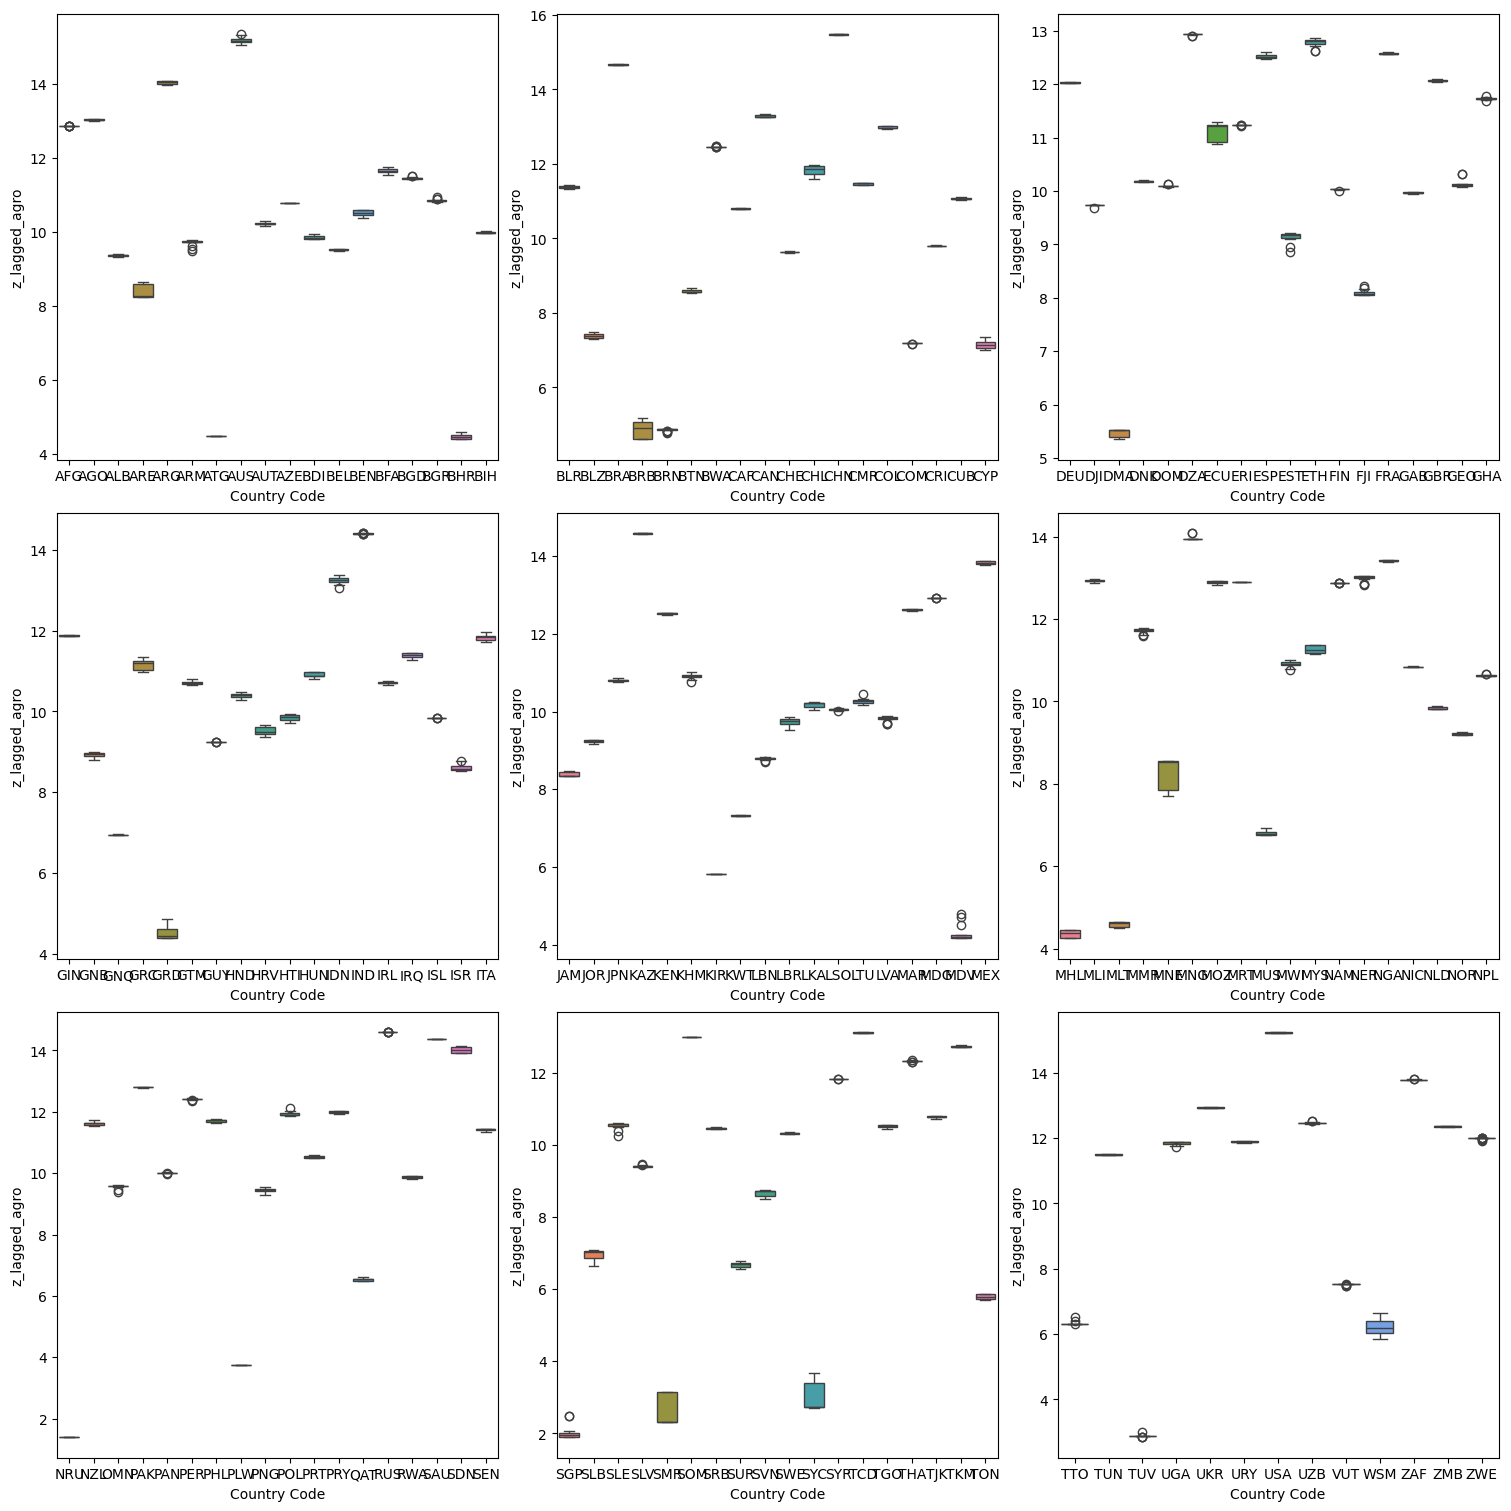

In [46]:
#Dividing by contries
countries = agro['Country Code'].unique()
countries_per_fig = 18
plots_per_row = 3
palette = sns.color_palette("hsv", len(countries))

# Split the countries into groups of the defined size
country_groups = [countries[i:i + countries_per_fig] for i in range(0, len(countries), countries_per_fig)]

num_rows = int(np.ceil(len(country_groups) / plots_per_row))

# Create the grid of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows*5), constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the boxplots in the grid
for i, (group, ax) in enumerate(zip(country_groups, axes)):
    data = agro[agro['Country Code'].isin(group)]
    sns.boxplot(x='Country Code', y='z_lagged_agro', data= data, hue = 'Country Code', legend=False, ax=ax)
    #ax.set_title(f'')
    #ax.set_xlabel('')
    #ax.set_ylabel('')

# If there are any remaining subplots that are empty, hide them
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [47]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_agro'].quantile(0.25)
    Q3 = group['lagged_agro'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_agro'] < lower_bound) | (group['lagged_agro'] > upper_bound)]

# Detect outliers for each country
outliers = agro.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Get the number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()

# Function to remove the largest outliers until 4 or fewer remain
def remove_largest_outliers(group):
    if len(group) <= 4:
        return group
    # Sort the outliers by their absolute deviation from the mean
    group['deviation'] = (group['lagged_agro'] - group['lagged_agro'].mean()).abs()
    group = group.sort_values(by='deviation', ascending=False)
    return group.iloc[4:]  # Keep only the rows after removing the largest outliers

# Remove the largest outliers for each country until 4 or fewer remain
outliers_reduced = outliers.groupby('Country Code').apply(remove_largest_outliers).reset_index(drop=True)

# Total number of remaining outliers
total_outliers_reduced = outliers_reduced.shape[0]
print("\nTotal number of remaining outliers:", total_outliers_reduced)

# Number of remaining outliers per country
remaining_outliers_per_country = outliers_reduced.groupby('Country Code').size()
print("\nNumber of remaining outliers per 'Country Code':")
print(remaining_outliers_per_country)

# Filter the original data to remove the detected outliers
agro = agro[~agro.index.isin(outliers_reduced.index)]

# Display the filtered data
print("\nFiltered data without the largest outliers:")
print(agro)


Total number of remaining outliers: 114

Number of remaining outliers per 'Country Code':
Country Code
AFG    2
ARM    3
AUS    2
BGD    2
BGR    3
BRN    2
BWA    1
COM    2
DJI    1
DOM    2
DZA    2
ERI    3
EST    2
ETH    2
FIN    1
FJI    2
GEO    2
GHA    2
GUY    3
IND    2
ISL    3
ISR    4
KHM    1
LBN    2
LTU    1
LVA    3
MDG    3
MDV    3
MMR    2
MNG    2
MUS    1
NAM    4
NER    3
NPL    2
OMN    2
PAN    2
PER    2
POL    1
RUS    1
SGP    2
SLE    2
SLV    2
SYR    2
THA    3
TKM    1
TTO    3
TUV    4
UGA    1
UZB    2
VUT    4
ZAF    2
ZWE    3
dtype: int64

Filtered data without the largest outliers:
     Country Code         Country Name    Year  agricultural_land  population  \
114           ATG  Antigua and Barbuda  2005.0               90.0     79869.0   
115           ATG  Antigua and Barbuda  2006.0               90.0     80895.0   
116           ATG  Antigua and Barbuda  2007.0               90.0     82016.0   
117           ATG  Antigua and Barbuda  2008.0

## Spliting the Data

In [48]:
from sklearn.model_selection import GroupShuffleSplit

In [49]:
#Defining the features (X) and the target variable (y)
X = agro.drop(columns=['Country Name', 'lagged_agro', 'agricultural_land', 'z_lagged_agro']) 
y = agro['z_lagged_agro'] 

#Defining the group variable (Country)
groups = agro['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [50]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1883, 12) (1883,)
Validation set shape: (414, 12) (414,)
Test set shape: (414, 12) (414,)


In [51]:
display(X_train)
display(y_train)

,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health
114,ATG,2005.0,79869.0,440.0,0.533180,0.830513,0.447558,0.584639,0.659244,0.742446,53.538085,0.462600
115,ATG,2006.0,80895.0,440.0,0.631312,0.799821,0.407992,0.547180,0.921212,1.119616,61.485529,0.462462
116,ATG,2007.0,82016.0,440.0,0.543636,0.802670,0.399155,0.530372,0.893503,1.146967,61.998878,0.446796
117,ATG,2008.0,83251.0,440.0,0.573909,0.813892,0.498479,0.642759,0.937939,1.276775,71.902239,0.457956
118,ATG,2009.0,84534.0,440.0,0.589428,0.721794,0.497975,0.653302,0.972667,1.317765,74.245866,0.456524
...,...,...,...,...,...,...,...,...,...,...,...,...
2820,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969
2821,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198
2822,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720
2823,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355


114      4.499810
115      4.499810
116      4.499810
117      4.499810
118      4.499810
          ...    
2820    11.995352
2821    11.995352
2822    11.995352
2823    11.995352
2824    11.995352
Name: z_lagged_agro, Length: 1883, dtype: float64

## Baseline Median Dummy Model 

- **Data Preparation:**
  - Import necessary libraries for numerical computations and model evaluation.
  - Convert the 'lagged_ghg' column in the dataset (`ghg_model`) to numeric data type.
  - Define a function `detect_outliers` to identify outliers using the Interquartile Range (IQR) method within each group of data.
  - Apply the outlier detection function to group the data by 'Country Code' and identify outliers.
  - Print the total number of outliers and the number of outliers per country.
  
- **Data Splitting:**
  - Define features (`X`) and the target variable (`y`) by excluding certain columns from the dataset.
  - Define the grouping variable (`groups`) based on 'Country Code'.
  - Initialize a GroupShuffleSplit object (`gss_outer`) to split the data into training and test sets while preserving groups.
  - Split the data into training and test sets, and further split the test set into validation and test sets using nested GroupShuffleSplit objects.
  - Print the shapes of the training, validation, and test sets.

- **Model Evaluation:**
  - Initialize a list (`performances`) to store performance metrics.
  - For each data split (train, val, test):
    - Calculate the median of 'lagged_ghg' for each country in the current split.
    - Merge the median values back to the current data split.
    - Use the median 'lagged_ghg' as predictions for the baseline model.
    - Calculate performance metrics (MAE, RMSE, MAPE, R2) for the baseline model on the current data split and append them to the `performances` list.

- **Performance Visualization:**
  - Print the performance metrics (MAE, RMSE, MAPE, R2) for each model split.
  - Visualize the performance metrics using scatterplots sorted by RMSE, MAPE, MAE, and R2 for each model split.

In [52]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import pickle as pkl
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [62]:
#Defining the features (X) and the target variable (y)
X = agro.drop(columns=['Country Name', 'lagged_agro', 'agricultural_land']) 
y = agro['log_lagged_agro'] 

#Defining the group variable (Country)
groups = agro['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [63]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1962, 14) (1962,)
Validation set shape: (431, 14) (431,)
Test set shape: (432, 14) (432,)


In [64]:
# Calculate median lagged_agro for X_train
median_lagged_agro_train = X_train['log_lagged_agro'].median()

# Function to add median values to a dataset
def add_median_values(df, median_value):
    df['median_prediction'] = median_value
    return df

# List of datasets to process
datasets = [(X_train, 'X_train'), (X_val, 'X_val'), (X_test, 'X_test')]

# Iterate over the datasets and add the median values
for x, name in datasets:
    x = add_median_values(x, median_lagged_agro_train)

# Now X_train, X_val, and X_test have the new column 'median_lagged_agro'


C:\Users\marc1\AppData\Local\Temp\ipykernel_24184\3379224918.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['median_prediction'] = median_value


In [65]:
sorted_X_val = X_val.sort_values(by='Country Code')
display(sorted_X_val)


,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,z_lagged_agro,log_lagged_agro,median_prediction
324,BLR,1996.0,10159569.0,202854.0,-0.819773,0.093739,-0.380564,-1.093997,-0.798984,-0.389609,-26.930450,0.277086,11.435180,11.435180,10.518224
341,BLR,2016.0,9469379.0,202988.0,-1.339389,0.135706,-0.513336,-1.090833,-0.765371,-0.224087,65.315758,0.248201,11.324304,11.324304,10.518224
340,BLR,2015.0,9461076.0,202978.0,-1.465074,0.110906,-0.489002,-1.166400,-0.878961,-0.315780,64.918447,0.242570,11.337023,11.337023,10.518224
339,BLR,2014.0,9448515.0,202973.0,-1.442869,0.179782,-0.489301,-1.099450,-0.815034,-0.234707,63.960828,0.242552,11.344862,11.344862,10.518224
338,BLR,2013.0,9443211.0,202908.0,-1.544429,0.005959,-0.961325,-1.159445,-0.881984,-0.404938,63.181042,0.245107,11.349700,11.349700,10.518224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,USA,1998.0,275854000.0,9158960.0,1.336877,0.879613,1.698527,1.610037,1.566960,1.549399,30.182924,0.217347,15.233943,15.233943,10.518224
2699,USA,1996.0,269394000.0,9158960.0,1.348661,0.935006,1.524920,1.593102,1.500219,1.571041,35.015993,0.217347,15.237170,15.237170,10.518224
2715,USA,2015.0,320738994.0,9147420.0,1.109839,0.662890,1.433120,1.242207,1.562773,1.358334,57.419142,0.192226,15.216226,15.216226,10.518224
2706,USA,2006.0,298379912.0,9161920.0,1.101622,0.490835,1.581686,1.640943,1.592660,1.344893,50.852697,0.209119,15.219133,15.219133,10.518224


In [67]:
performances = []

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    
    
    # Calculate performance metrics for the baseline model on the current data split
    mae = mean_absolute_error(y, x['median_prediction'])
    mse = mean_squared_error(y, x['median_prediction'])  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE
    mape = mean_absolute_percentage_error(y, x['median_prediction'])
    r2 = r2_score(y, x['median_prediction'])

    performances.append({
        'model': name,
        'split': nsplit,
        'mae': round(mae, 4),
        'rmse': round(rmse, 4),
        'mape': round(mape, 4),
        'r2': round(r2, 4)
    })

In [68]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  2.789
MAE:  2.1061
MAPE:  0.3084
R2:  -0.0165


Model:  X_val
Split:  val
RMSE:  2.467
MAE:  1.9861
MAPE:  0.1878
R2:  -0.0465


Model:  X_test
Split:  test
RMSE:  3.811
MAE:  2.8043
MAPE:  0.7625
R2:  -0.0493




In [69]:
perf_df = pd.DataFrame(performances)

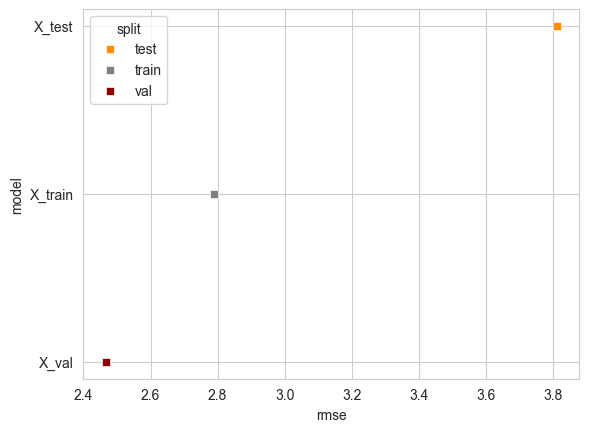

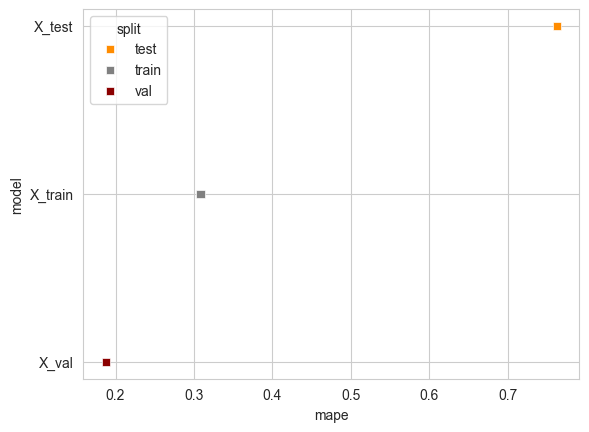

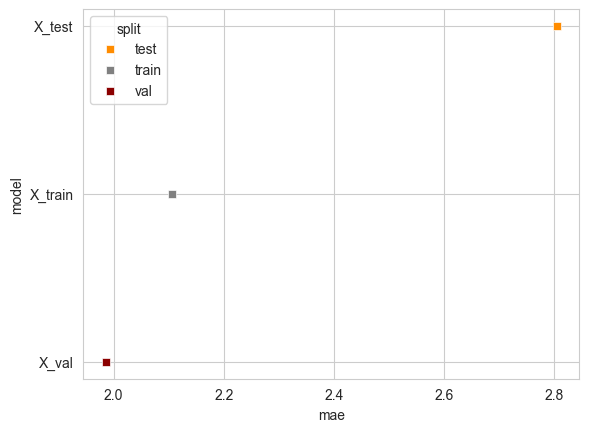

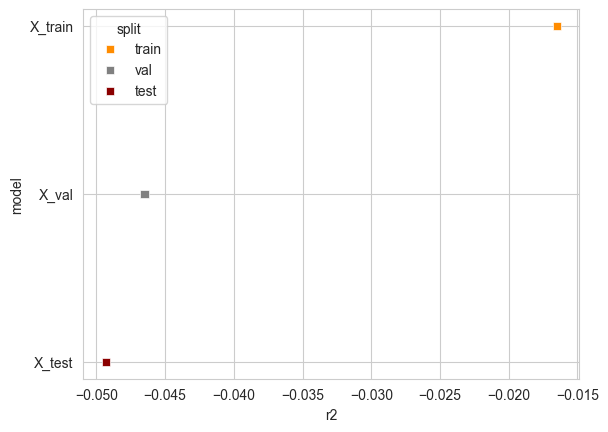

In [70]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [32]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

c:\Users\marc1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Combined MERF Model

In [46]:
# Initialize a list to store performance metrics
performances = []

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is 528.2458299329678 at iteration 1.
INFO     [merf.py:307] Training GLL is 577.4423513927867 at iteration 2.
INFO     [merf.py:307] Training GLL is 505.2481077337051 at iteration 3.
INFO     [merf.py:307] Training GLL is 529.5233190563303 at iteration 4.
INFO     [merf.py:307] Training GLL is 506.30897502719614 at iteration 5.
INFO     [merf.py:307] Training GLL is 439.69458879013445 at iteration 6.
INFO     [merf.py:307] Training GLL is 241.88001406773327 at iteration 7.
INFO     [merf.py:307] Training GLL is 366.22119633223156 at iteration 8.
INFO     [merf.py:307] Training GLL is 213.6782529613507 at iteration 9.
INFO     [merf.py:307] Training GLL is -31.8552940578192 at iteration 10.
INFO     [merf.py:307] Training GLL is 48.718562745507874 at iteration 11.
INFO     [merf.py:307] Training GLL is -115.19618727863573 at iteration 12.
INFO     [merf.py:307] Training GLL is -165.5627505753761 at iteration 13.
INFO     [merf.py:307] Training GLL is 

In [47]:
print(performances)

[{'model': 'X_train', 'split': 'train', 'rmse': 0.659, 'mae': 0.3919, 'mape': 0.019, 'r2': 0.999}, {'model': 'X_val', 'split': 'val', 'rmse': 23.9204, 'mae': 17.8866, 'mape': 2.4478, 'r2': 0.0663}, {'model': 'X_test', 'split': 'test', 'rmse': 19.5792, 'mae': 15.9256, 'mape': 2.3708, 'r2': 0.2099}]


In [48]:
perf_df = pd.DataFrame(performances)

In [50]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.659
MAE:  0.3919
MAPE:  0.019
R2:  0.999


Model:  X_val
Split:  val
RMSE:  23.9204
MAE:  17.8866
MAPE:  2.4478
R2:  0.0663


Model:  X_test
Split:  test
RMSE:  19.5792
MAE:  15.9256
MAPE:  2.3708
R2:  0.2099




In [51]:
# Calculate the range of values for y_train
y_train_min = y_train.min()
y_train_max = y_train.max()

# Print the range
print(f"Range of y_train: {y_train_min} to {y_train_max}")

Range of y_train: 2.27703984819734 to 84.3135152680571


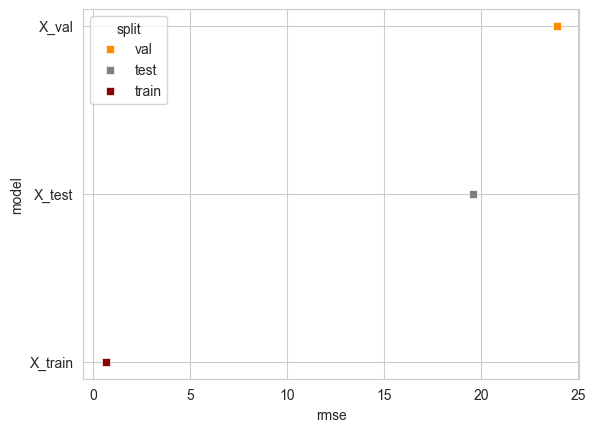

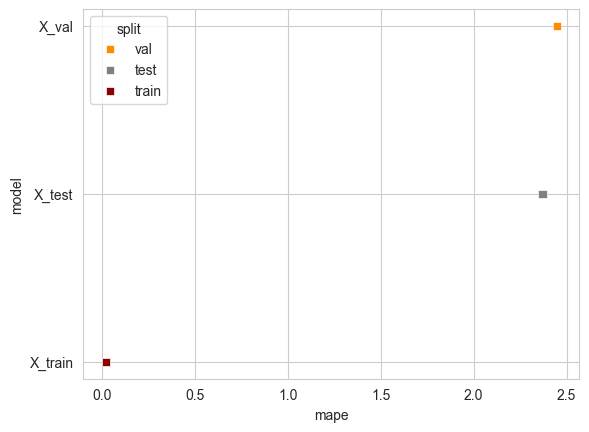

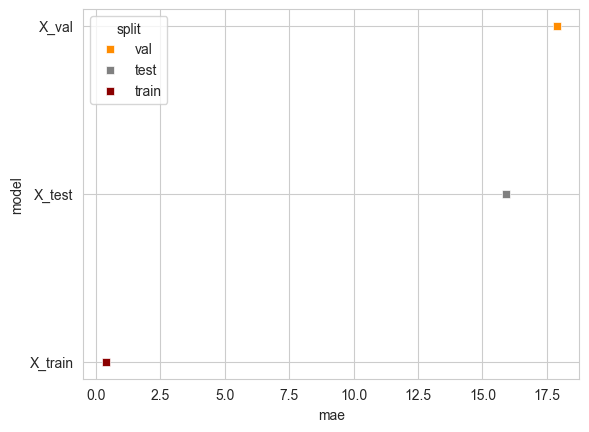

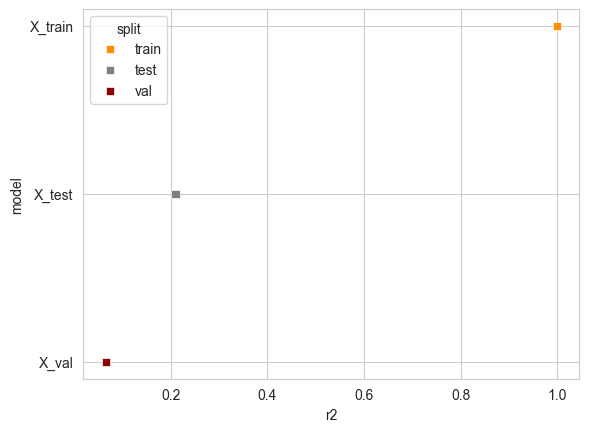

In [52]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

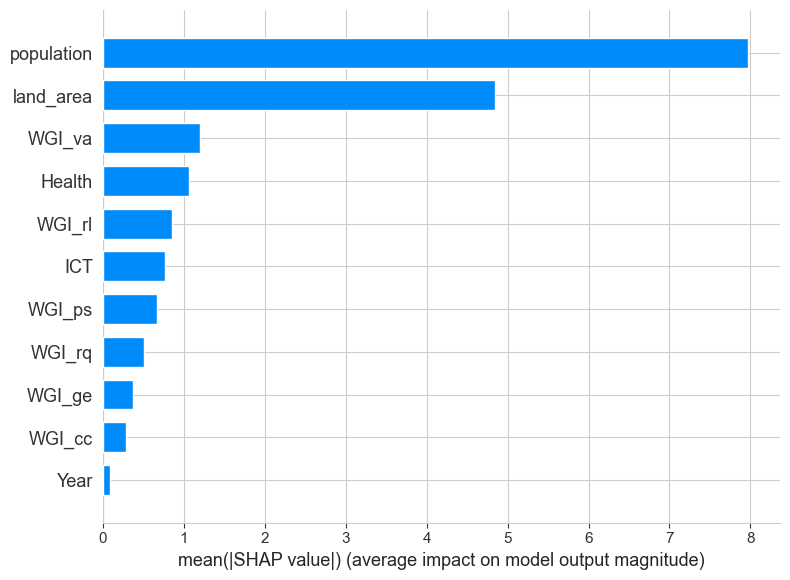

In [53]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [55]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is 524.1229633301504 at iteration 1.
INFO     [merf.py:307] Training GLL is 586.6355143635536 at iteration 2.
INFO     [merf.py:307] Training GLL is 624.5096182627617 at iteration 3.
INFO     [merf.py:307] Training GLL is 581.6286001331939 at iteration 4.
INFO     [merf.py:307] Training GLL is 497.7390379137346 at iteration 5.
INFO     [merf.py:307] Training GLL is 399.07031922932015 at iteration 6.
INFO     [merf.py:307] Training GLL is 373.30756499007515 at iteration 7.
INFO     [merf.py:307] Training GLL is 313.7668765623699 at iteration 8.
INFO     [merf.py:307] Training GLL is 179.65414019415516 at iteration 9.
INFO     [merf.py:307] Training GLL is 319.4177969398832 at iteration 10.
INFO     [merf.py:307] Training GLL is 56.17621428706844 at iteration 11.
INFO     [merf.py:307] Training GLL is 101.51762237292392 at iteration 12.
INFO     [merf.py:307] Training GLL is 20.946146780488426 at iteration 13.
INFO     [merf.py:307] Training GLL is -46

In [56]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.6851
MAE:  0.3924
MAPE:  0.0195
R2:  0.999


Model:  X_val
Split:  val
RMSE:  26.7176
MAE:  19.5932
MAPE:  2.2723
R2:  -0.1649


Model:  X_test
Split:  test
RMSE:  22.3162
MAE:  17.7237
MAPE:  2.1936
R2:  -0.0264




In [57]:
perf_df = pd.DataFrame(performances)

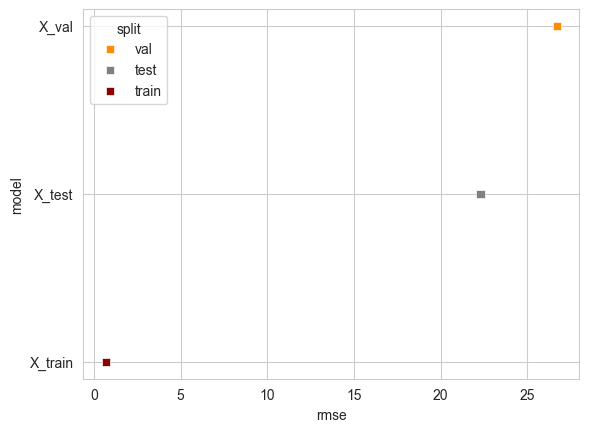

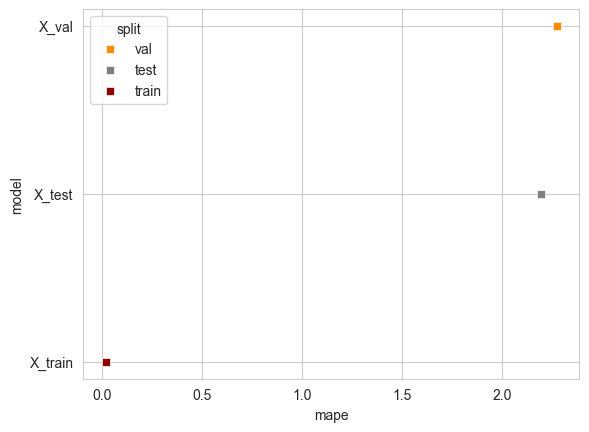

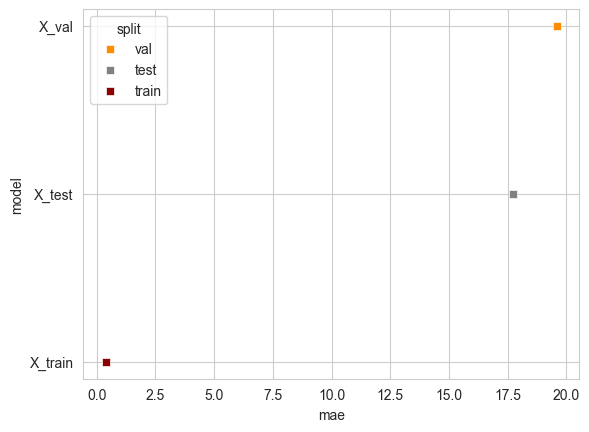

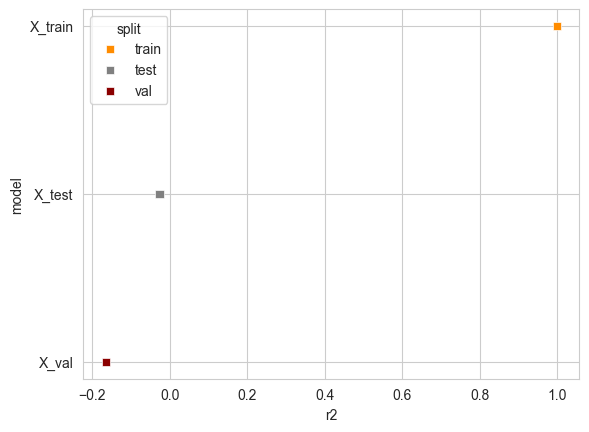

In [58]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

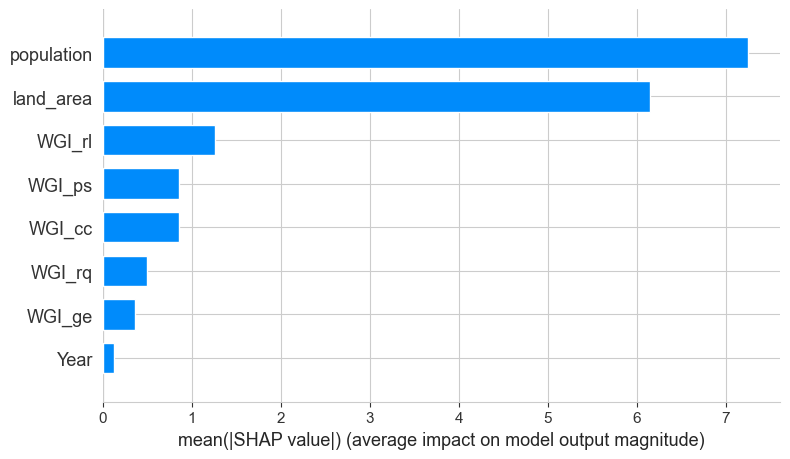

In [59]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [60]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Social Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is 569.4374776881123 at iteration 1.
INFO     [merf.py:307] Training GLL is 566.4075576958144 at iteration 2.
INFO     [merf.py:307] Training GLL is 582.8637748508528 at iteration 3.
INFO     [merf.py:307] Training GLL is 508.1113766032341 at iteration 4.
INFO     [merf.py:307] Training GLL is 263.25739932708547 at iteration 5.
INFO     [merf.py:307] Training GLL is 379.3391272371355 at iteration 6.
INFO     [merf.py:307] Training GLL is 265.34699434897317 at iteration 7.
INFO     [merf.py:307] Training GLL is 116.7402632778231 at iteration 8.
INFO     [merf.py:307] Training GLL is 71.52690200882078 at iteration 9.
INFO     [merf.py:307] Training GLL is -39.701588910942846 at iteration 10.
INFO     [merf.py:307] Training GLL is -86.36938257186532 at iteration 11.
INFO     [merf.py:307] Training GLL is -118.58547569723656 at iteration 12.
INFO     [merf.py:307] Training GLL is -292.667899623503 at iteration 13.
INFO     [merf.py:307] Training GLL is -

In [61]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.6539
MAE:  0.3637
MAPE:  0.0172
R2:  0.9991


Model:  X_val
Split:  val
RMSE:  26.4127
MAE:  19.56
MAPE:  2.5841
R2:  -0.1385


Model:  X_test
Split:  test
RMSE:  19.4307
MAE:  15.8804
MAPE:  1.9552
R2:  0.2219




In [62]:
perf_df = pd.DataFrame(performances)

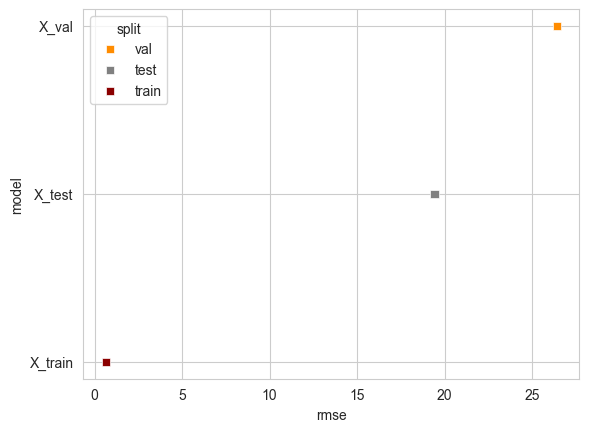

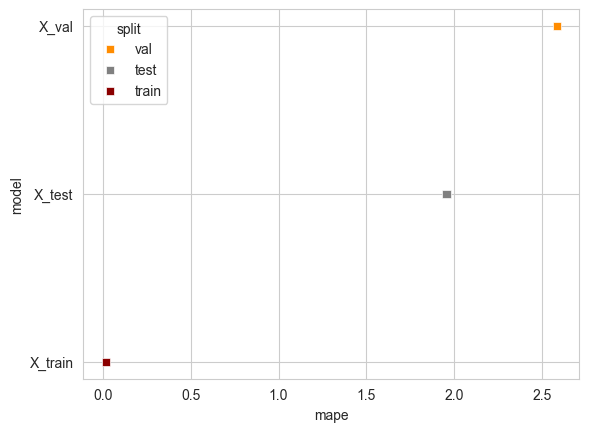

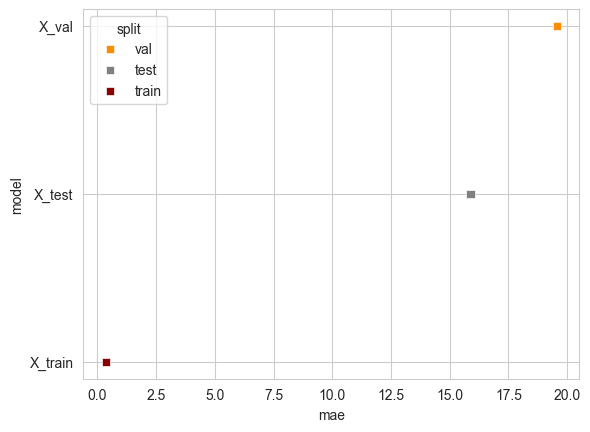

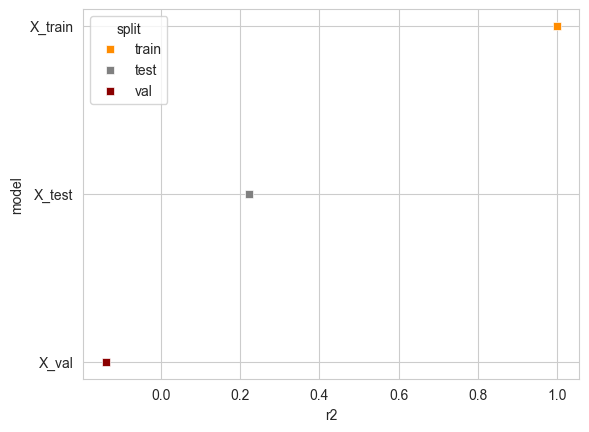

In [63]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

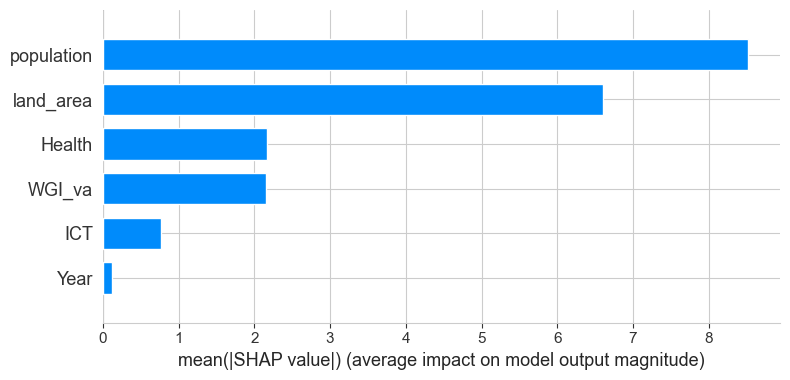

In [64]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

# Z REMIX

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [77]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap
from sklearn.preprocessing import StandardScaler


In [143]:
scaler = StandardScaler()

# Fit the scaler to the 'lagged_agro' column and transform it
agro['z_lagged_agro'] = scaler.fit_transform(agro[['lagged_agro']])

In [130]:
display(agro)

,Country Code,Country Name,Year,agricultural_land,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_agro,z_lagged_agro
0,AFG,Afghanistan,1996.0,57.889088,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,57.945817,0.844332
1,AFG,Afghanistan,1998.0,58.059274,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,57.939684,0.844055
2,AFG,Afghanistan,2000.0,57.945817,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,58.151266,0.853638
3,AFG,Afghanistan,2002.0,57.939684,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,58.123668,0.852388
4,AFG,Afghanistan,2003.0,58.083805,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,58.129801,0.852666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,ZWE,Zimbabwe,2012.0,41.876696,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,41.876696,0.116513
2768,ZWE,Zimbabwe,2013.0,41.876696,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,41.876696,0.116513
2769,ZWE,Zimbabwe,2014.0,41.876696,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,41.876696,0.116513
2770,ZWE,Zimbabwe,2015.0,41.876696,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,41.876696,0.116513


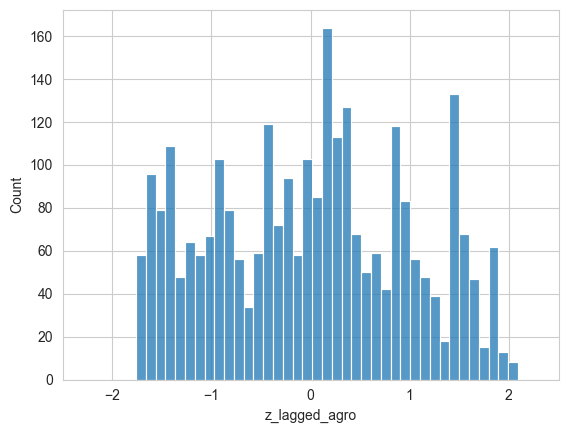

In [83]:
sns.histplot(data=agro, x='z_lagged_agro', binwidth=0.1)
# Setting x-axis limit
plt.xlim(left=-2.5)
plt.xlim(right=2.5)
plt.show()

### Combined MERF Model

In [87]:
# Initialize a list to store performance metrics
performances = []

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7319.037540602437 at iteration 1.
INFO     [merf.py:307] Training GLL is -11360.763241247154 at iteration 2.
INFO     [merf.py:307] Training GLL is -12014.491401314688 at iteration 3.
INFO     [merf.py:307] Training GLL is -12097.554208365287 at iteration 4.
INFO     [merf.py:307] Training GLL is -12313.799344238847 at iteration 5.
INFO     [merf.py:307] Training GLL is -12456.646378196529 at iteration 6.
INFO     [merf.py:307] Training GLL is -12542.68165440647 at iteration 7.
INFO     [merf.py:307] Training GLL is -12583.059792287677 at iteration 8.
INFO     [merf.py:307] Training GLL is -12679.900448836925 at iteration 9.
INFO     [merf.py:307] Training GLL is -12851.728609202371 at iteration 10.
INFO     [merf.py:307] Training GLL is -12835.344884067741 at iteration 11.
INFO     [merf.py:307] Training GLL is -12854.030356583598 at iteration 12.
INFO     [merf.py:307] Training GLL is -12919.875943092904 at iteration 13.
INFO     [merf.py:307] 

In [88]:
print(performances)

[{'model': 'X_train', 'split': 'train', 'rmse': 0.031, 'mae': 0.0177, 'mape': 0.0714, 'r2': 0.999}, {'model': 'X_val', 'split': 'val', 'rmse': 1.1269, 'mae': 0.928, 'mape': 1.8841, 'r2': 0.0191}, {'model': 'X_test', 'split': 'test', 'rmse': 1.0984, 'mae': 0.8436, 'mape': 2.3788, 'r2': -0.4067}]


In [89]:
perf_df = pd.DataFrame(performances)

In [90]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.031
MAE:  0.0177
MAPE:  0.0714
R2:  0.999


Model:  X_val
Split:  val
RMSE:  1.1269
MAE:  0.928
MAPE:  1.8841
R2:  0.0191


Model:  X_test
Split:  test
RMSE:  1.0984
MAE:  0.8436
MAPE:  2.3788
R2:  -0.4067




In [91]:
# Calculate the range of values for y_train
y_train_min = y_train.min()
y_train_max = y_train.max()

# Print the range
print(f"Range of y_train: {y_train_min} to {y_train_max}")

Range of y_train: -1.759885968069495 to 1.9045543803075873


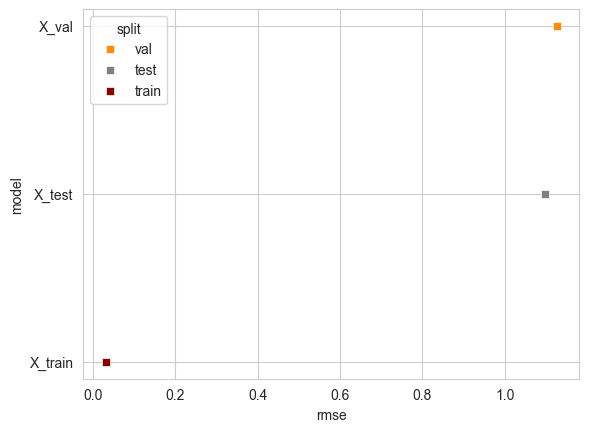

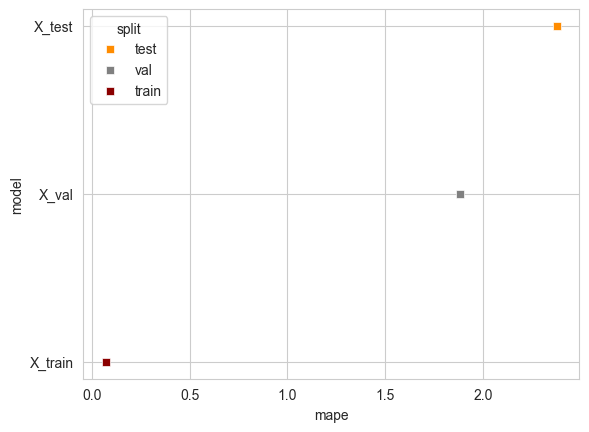

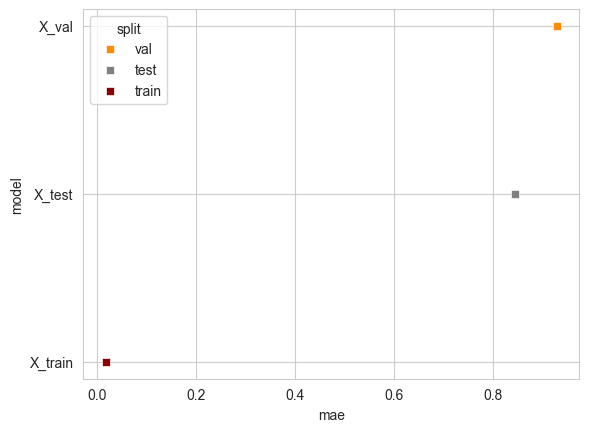

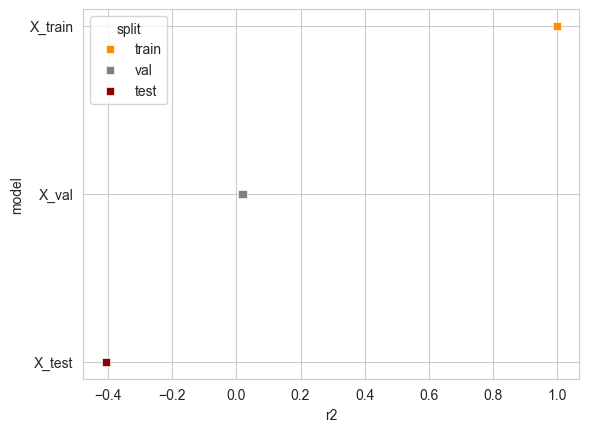

In [92]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

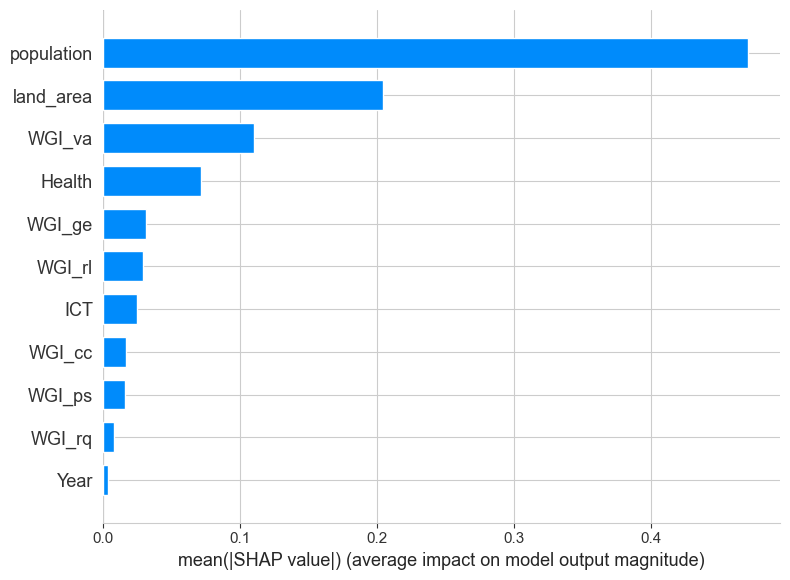

In [93]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [94]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7260.227701783218 at iteration 1.
INFO     [merf.py:307] Training GLL is -10852.704621810459 at iteration 2.
INFO     [merf.py:307] Training GLL is -11558.114207139146 at iteration 3.
INFO     [merf.py:307] Training GLL is -11825.778475026495 at iteration 4.
INFO     [merf.py:307] Training GLL is -11906.293219999216 at iteration 5.
INFO     [merf.py:307] Training GLL is -12163.209440642424 at iteration 6.
INFO     [merf.py:307] Training GLL is -12274.914472109323 at iteration 7.
INFO     [merf.py:307] Training GLL is -12377.672438593436 at iteration 8.
INFO     [merf.py:307] Training GLL is -12470.057902156017 at iteration 9.
INFO     [merf.py:307] Training GLL is -12550.92877707574 at iteration 10.
INFO     [merf.py:307] Training GLL is -12581.445954313116 at iteration 11.
INFO     [merf.py:307] Training GLL is -12624.598570095372 at iteration 12.
INFO     [merf.py:307] Training GLL is -12870.470711096237 at iteration 13.
INFO     [merf.py:307] 

In [95]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0315
MAE:  0.0191
MAPE:  0.0775
R2:  0.999


Model:  X_val
Split:  val
RMSE:  1.1404
MAE:  0.9336
MAPE:  1.7101
R2:  -0.0047


Model:  X_test
Split:  test
RMSE:  1.2403
MAE:  1.0165
MAPE:  2.7975
R2:  -0.7936




In [96]:
perf_df = pd.DataFrame(performances)

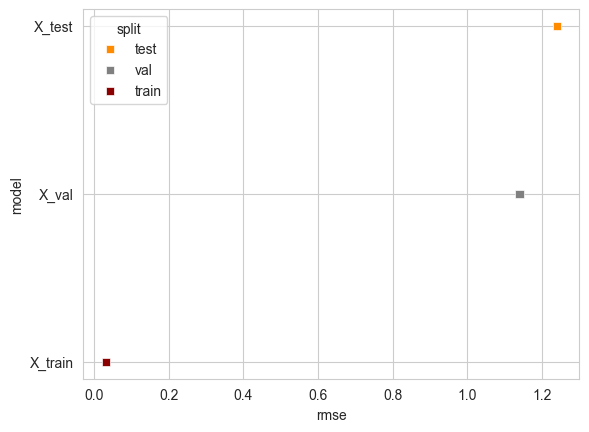

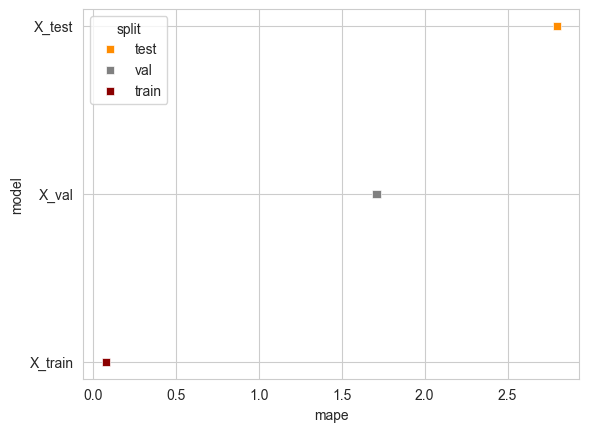

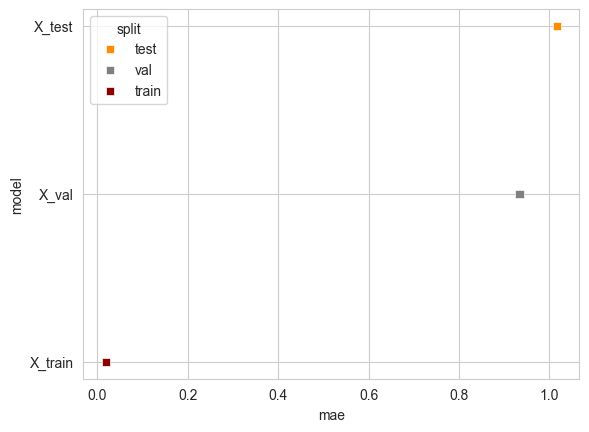

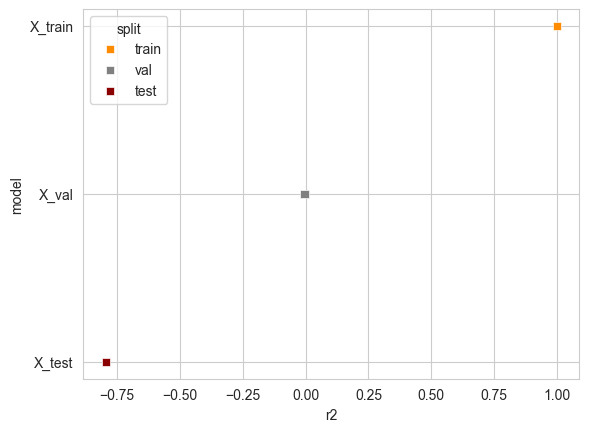

In [97]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

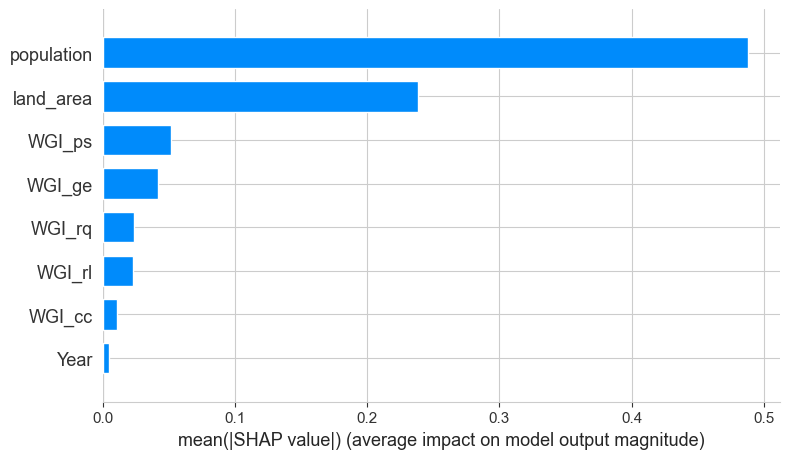

In [98]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [99]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Social Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7349.936085901886 at iteration 1.
INFO     [merf.py:307] Training GLL is -11512.103415038875 at iteration 2.
INFO     [merf.py:307] Training GLL is -12278.600555535084 at iteration 3.
INFO     [merf.py:307] Training GLL is -12209.98964767302 at iteration 4.
INFO     [merf.py:307] Training GLL is -12136.871029545133 at iteration 5.
INFO     [merf.py:307] Training GLL is -12409.508532645821 at iteration 6.
INFO     [merf.py:307] Training GLL is -12492.505018825674 at iteration 7.
INFO     [merf.py:307] Training GLL is -12440.780492129505 at iteration 8.
INFO     [merf.py:307] Training GLL is -12696.301930256395 at iteration 9.
INFO     [merf.py:307] Training GLL is -12711.145324136995 at iteration 10.
INFO     [merf.py:307] Training GLL is -12784.052852160035 at iteration 11.
INFO     [merf.py:307] Training GLL is -12968.992591301994 at iteration 12.
INFO     [merf.py:307] Training GLL is -12985.985092569954 at iteration 13.
INFO     [merf.py:307] 

In [100]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0292
MAE:  0.0164
MAPE:  0.0701
R2:  0.9991


Model:  X_val
Split:  val
RMSE:  1.1534
MAE:  0.9589
MAPE:  1.9496
R2:  -0.0277


Model:  X_test
Split:  test
RMSE:  1.1655
MAE:  0.9389
MAPE:  6.8513
R2:  -0.584




In [101]:
perf_df = pd.DataFrame(performances)

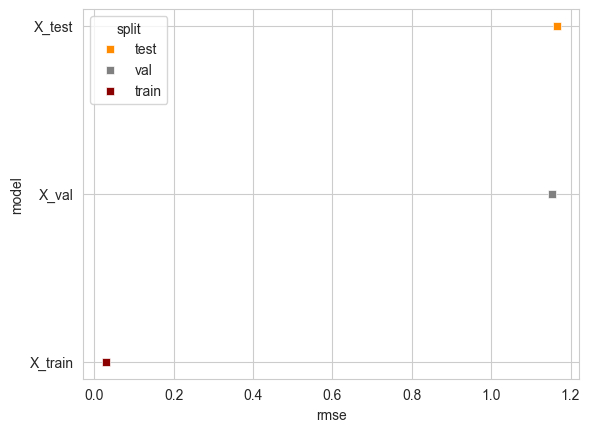

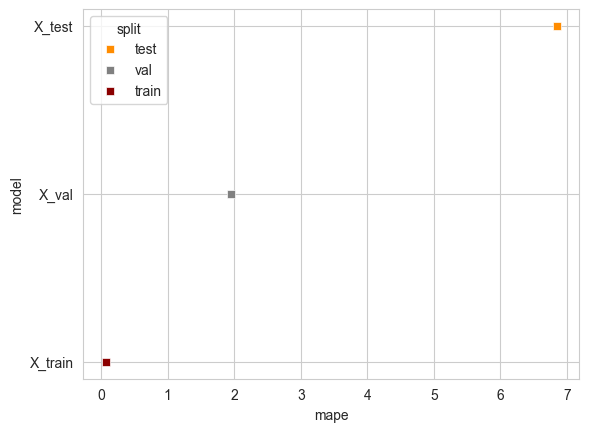

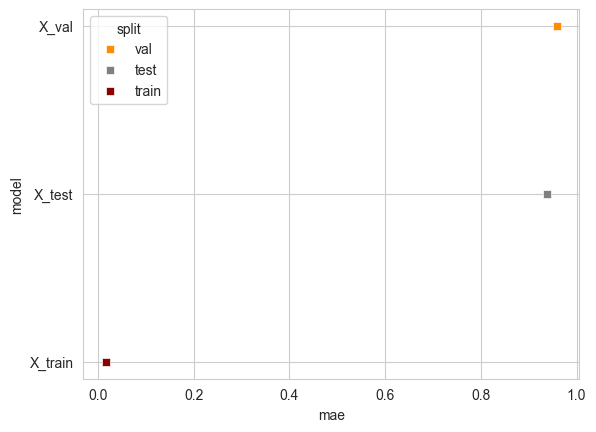

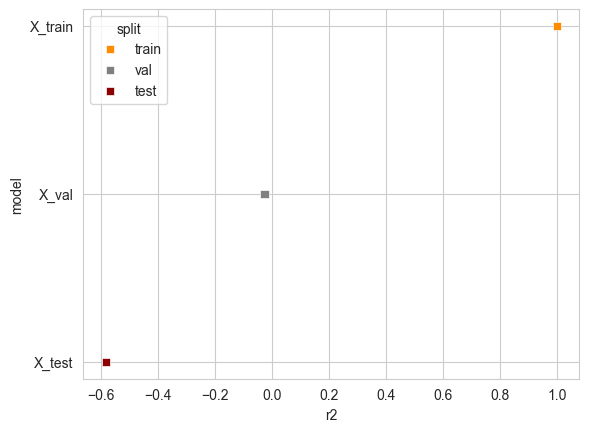

In [102]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

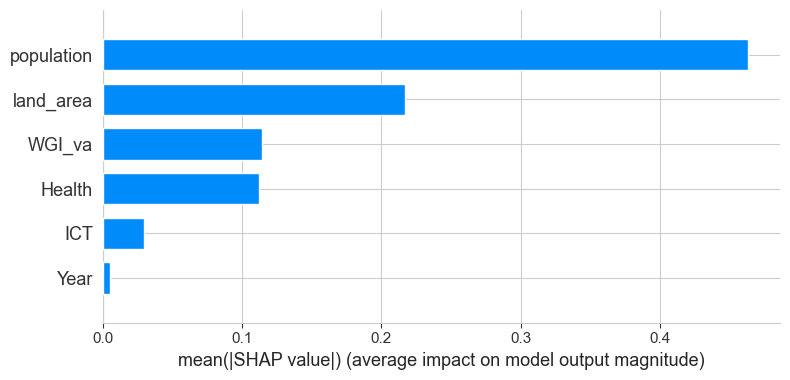

In [103]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")